In [1]:
%run imports.ipynb

Генеришемо жељени дводимензионални синтетички скуп података тако што задајемо потребне атрибуте и позивамо скрипту generate_2d.ipynb.

In [2]:
shape = "aniso"
n_samples = 3000
outliers_fraction = 0.05

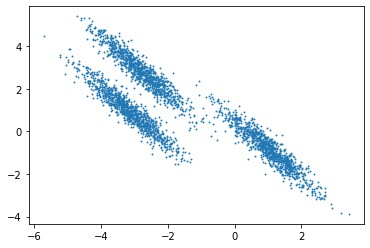

In [3]:
%run generate_2d.ipynb

У скрипти estimate_density2.ipynb оцењујемо функцију густине помоћу Гаусовог кернела. Ширину кернела бирамо 10-слојном унакрсном валидацијом на скупу .

{'bandwidth': 0.1}


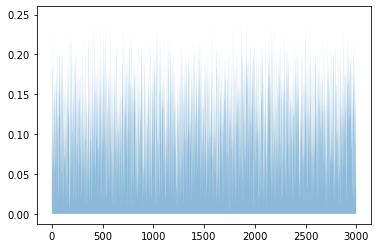

In [4]:
%run estimate_density2.ipynb

In [5]:
x.shape

(3000, 2)

In [7]:
min(vec), max(vec)

(0.005305164769729847, 0.24784925735581112)

Правимо KDTree структуру коју ћемо користити за израчунавање Рипсовог графа и надниво филтрације у имплементацији алгоритма.

In [8]:
kdt = KDTree(x, metric='euclidean')

Конструишемо дендрограм помоћу single linkage методе кластеровања.

In [333]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(x, 'single')

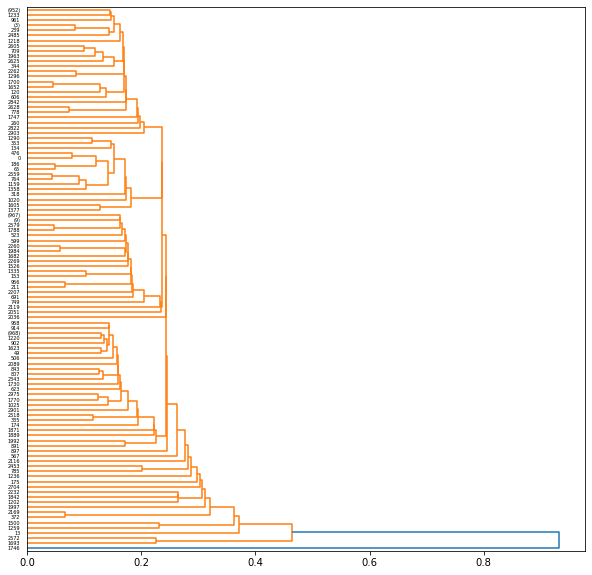

In [334]:
plt.figure(figsize=(10,10))
dn = hierarchy.dendrogram(Z, p=30,truncate_mode='level', orientation='right')

На основу релевантне скале добијене дендрограмом правимо график зависности просечног броја суседа од радијуса у Рипсовом графу и примењујемо методу лакта за финални избор параметра.

In [335]:
rads = np.linspace(0, 1, 20)
count_neis = [np.mean([kdt.query_radius([x[i]], rads[j], return_distance=False)[0].shape[0] for i in np.arange(x.shape[0])]) 
           for j in range(len(rads))]

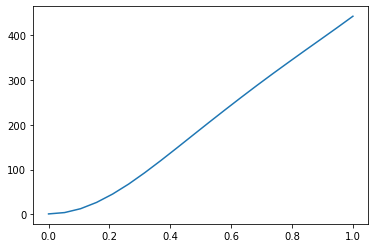

In [336]:
%matplotlib inline
plt.plot(rads, count_neis)

In [9]:
radius = 0.2

Пре покретања алгоритма иницијализујемо дисјунктни-сет структуру и сортирамо индексе тачака у подацима по опадајућој вредности функције густине.

In [10]:
%run unionfind.ipynb

In [11]:
index_sorted = [i for (e,i) in sorted([(e,i) for i,e in enumerate(vec)])]

In [12]:
vec_sorted = {i:e for (e,i) in sorted([(e,i) for i,e in enumerate(vec)])}

In [13]:
vec_sorted

{1746: 0.005305164769729847,
 13: 0.005319423614237812,
 175: 0.005378007749205866,
 1997: 0.0054010890059282375,
 2116: 0.005422595206310368,
 2704: 0.005422980446399072,
 1236: 0.005423551613053842,
 2232: 0.005468558918644993,
 1202: 0.005530781168976934,
 1842: 0.005629643456158003,
 897: 0.005651245954815965,
 1500: 0.005678774429975552,
 1259: 0.0056864543074666846,
 1693: 0.00572137950758655,
 2572: 0.005721489196854685,
 2036: 0.005773954834577682,
 1889: 0.005926756406967119,
 567: 0.00601833437978373,
 785: 0.006020040548369473,
 2453: 0.006140399706672554,
 2051: 0.006370610329653403,
 1871: 0.006465271773773677,
 2119: 0.006488039166138045,
 749: 0.006565616676286236,
 891: 0.006591079823143174,
 2207: 0.007065325399448115,
 2822: 0.00714890870819999,
 318: 0.007361766103086781,
 260: 0.007406119505300705,
 1020: 0.007430301960853986,
 1747: 0.0075329026306350955,
 2269: 0.007563711408642106,
 2842: 0.00760787112735199,
 344: 0.007665639937582934,
 1605: 0.00789375191894171

Главна функција за имплементацију ТоМАТо алгоритма која враћа хијерархију кластера:

In [39]:
def define_clusters(vec_sorted, radius, tau):

    unf = UnionFind()
    n=len(vec)
    births = {}
    deaths = {}
    for i in reversed(range(n)):
        idx = index_sorted[i]
        nei = kdt.query_radius([x[idx]], radius, return_distance=False)[0]
        S = [elem for elem in nei if elem in index_sorted[(i+1):]] 

        if not S:
            unf.insert_objects([idx]) 
            births[idx] = -vec_sorted[idx]
        else:
            parent = S[np.asarray([vec_sorted[j] for j in S]).argmax()]
            unf.union(parent, idx)
            roots = [unf.find(ele) for ele in S]
            highest = roots[np.asarray([vec_sorted[elem] for elem in roots]).argmax()]
            for root in roots:                   
                if (root != parent) & (vec_sorted[root] - vec_sorted[idx] < tau):
                    unf.union(parent, root)
                    deaths[root] = -vec_sorted[idx]
            if (highest != parent) & (vec_sorted[parent] - vec_sorted[idx] < tau):
                unf.union(highest, parent)
                deaths[parent] = -vec_sorted[idx]
    return unf, births, deaths

Функција за детекцију мода функције густине:

In [120]:
def define_modes(vec_sorted, radius):

    unf = UnionFind()
    n=len(vec)
    for i in reversed(range(n)):
        idx = index_sorted[i]
        nei = kdt.query_radius([x[idx]], radius, return_distance=False)[0]
        S = [elem for elem in nei if elem in index_sorted[(i+1):]] 

        if not S:
            unf.insert_objects([idx]) 
            births[idx] = -vec_sorted[idx]
        else:
            parent = S[np.asarray([vec_sorted[j] for j in S]).argmax()]
            unf.union(parent, idx)
    return unf

Прво покрећемо алгоритам за бесконачну вредност параметра спајања да бисмо добили значајност сваке моде функције густине.

In [54]:
unf, births, deaths = define_clusters(vec_sorted, radius=radius, tau=np.inf)

In [ ]:
unf = define_modes(vec_sorted, radius=radius)

На оснуву излаза првог покретања алгоритма рачунамо животне векове свих мода и на затим конструишемо хистограм значајности, перзистентни дијаграм и перзистентни бар-код.

In [56]:
for idx in list(births.keys()):
    if (idx not in list(deaths.keys())):
        deaths[idx] = np.inf

In [57]:
lifecycle = [(births[idx], deaths[idx]) for idx in list(births.keys())]

In [58]:
res = [(0, elem) for elem in lifecycle]
res

[(0, (-0.24784925735581112, -0.008006982784684256)),
 (0, (-0.24412169651277435, -0.13569443695072708)),
 (0, (-0.22305276153793988, -0.1528427927149902)),
 (0, (-0.24110328569718043, -0.14507870160651196)),
 (0, (-0.21819895957116398, -0.007065325399448115)),
 (0, (-0.23592712257886242, -0.14454971940476916)),
 (0, (-0.21274556681640686, -0.00714890870819999)),
 (0, (-0.2378451978600962, -0.18272524596974243)),
 (0, (-0.21110904289041493, -0.134922904525733)),
 (0, (-0.2249474758110321, -0.12382220378926377)),
 (0, (-0.22490995681879622, -0.17192209383443297)),
 (0, (-0.2316439657671734, -0.1476570956294221)),
 (0, (-0.2226803690456368, -0.16865200999804067)),
 (0, (-0.20229317256108548, -0.13285341266692313)),
 (0, (-0.22435377765368925, -0.1504773052995268)),
 (0, (-0.20055675067847611, -0.13633679652186473)),
 (0, (-0.23533984378890238, -0.19381490457898445)),
 (0, (-0.19548341887012824, -0.12691483473540516)),
 (0, (-0.2197303766440507, -0.15528493720086395)),
 (0, (-0.20289474837

In [59]:
persistence = [elem[1]-elem[0] for elem in lifecycle]
persistence

[0.23984227457112686,
 0.10842725956204727,
 0.07020996882294966,
 0.09602458409066847,
 0.21113363417171585,
 0.09137740317409326,
 0.20559665810820688,
 0.05511995189035376,
 0.07618613836468194,
 0.10112527202176834,
 0.052987862984363254,
 0.08398687013775127,
 0.05402835904759612,
 0.06943975989416235,
 0.07387647235416245,
 0.06421995415661139,
 0.04152493920991793,
 0.06856858413472308,
 0.06444543944318676,
 0.015195583342887842,
 0.07052408114509737,
 0.08055572506237413,
 0.012133514412390328,
 0.0911049856004663,
 0.09896144297981611,
 0.0730797038418343,
 0.09657588061791268,
 0.09460512699913923,
 0.10419452904584689,
 0.10371481914218368,
 0.06541805158118663,
 0.028798607276087795,
 0.0697106048690756,
 0.04761363543175923,
 0.04768044071706026,
 0.04372490030635495,
 0.06253839906988401,
 0.07045559049216119,
 0.05308767408441009,
 0.04000260382194179,
 0.05393663678628077,
 0.06637240838316427,
 0.06250230568279438,
 0.08626569919050975,
 0.05146856477346823,
 0.024093

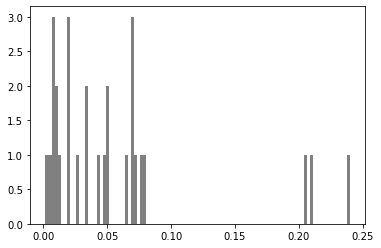

In [21]:
plt.hist([elem for elem in persistence if ~np.isinf(elem)], bins=100, color = 'gray')
plt.show()

In [60]:
lifecycle_mod = [(-elem[0], 0) if elem[1]==np.inf else (-elem[0], -elem[1]) for elem in lifecycle]

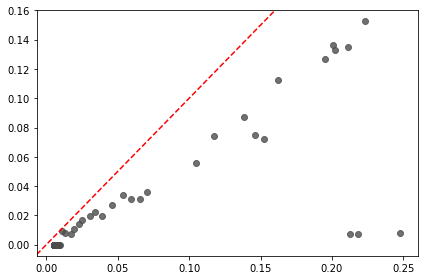

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter([elem[0] for elem in lifecycle_mod], [elem[1] for elem in lifecycle_mod], c=".3", alpha=0.8)
add_identity(ax, color='r', ls='--')
plt.tight_layout()
plt.show()

<Figure size 1296x288 with 0 Axes>

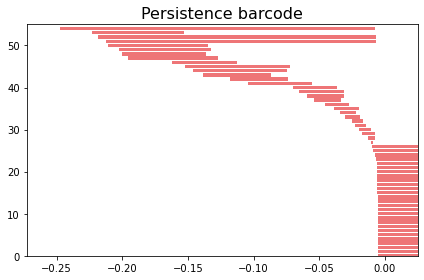

In [25]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gudhi.plot_persistence_barcode(res)
plt.tight_layout()
plt.show()

Покрећемо алгоритам други пут са новим параметром спајања добијеним на основу претходних визуализација.

In [50]:
unf, births, deaths = define_clusters(vec_sorted, radius=radius, tau = 0.2)

Број родитеља у дисјунктни-сет структури нам даје тачан број кластера.

In [51]:
len(np.unique(list(unf.parent_pointers.values())))

36

In [452]:
np.unique(list(unf.parent_pointers.values()))

array([   0,   56,   82, 2689, 2753, 2830, 2855, 2903, 2923, 2940, 2951,
       2964, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985,
       2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996,
       2997, 2998, 2999])

Правимо центроиде кластера и одређујемо припадност сваке тачке добијеним кластерима .

In [453]:
cen, sts = [], []
ind = np.asarray(list(unf.num_to_objects.values()))
rts = np.asarray(list(unf.parent_pointers.values()))

In [454]:
for ele in np.unique(rts):

    cen.append(unf.num_to_objects[ele])
    sts.append(ind[np.where(rts == ele)[0]])

In [455]:
cen = np.asarray(cen)

In [456]:
cen

array([1587, 2382, 1441,  969, 2479, 2778, 1159, 2605, 2260,  372, 2903,
       1992,  749, 2119, 1871, 2051, 2453,  785,  567, 1889, 2036, 2572,
       1693, 1259, 1500,  897, 1842, 1202, 2232, 1236, 2704, 2116, 1997,
        175,   13, 1746])

In [457]:
sts

[array([1587, 2141,  532, 1916, 2191,  171, 1868, 2678, 1787,  420, 2504,
         508,    3, 1778,  404,  781,  482,  361, 2164, 2392, 2982, 2873,
        2180,  702,  700, 1030, 2289, 2953, 1995,  184, 1143, 1882, 1072,
        2239, 1114, 2973, 2913,  332, 2718, 1474, 1789, 2580, 2000,  577,
        1156, 2108, 1961, 1648, 1575, 1045,  714,  302,  522, 2503, 1453,
         762, 2456, 1408,  859, 1912,  970,  197, 2135,  880,  196, 1168,
        2828, 2474, 1000, 2747, 1821, 1878,  110, 1394,   60,  498,  366,
        2817, 2148, 1636,  102,   18, 2038,  753,  165,  882, 2017, 2250,
        2298,  760, 2066, 1673,  911, 2327,  637,  365, 2599, 1146,  531,
         242, 1267,  766,  845, 2310, 1191,  255,   72, 1536, 1276,  638,
        1869, 1065,   29,  234, 2564, 2251,  744, 1656, 2078, 1318, 1925,
         465, 1739, 1145, 1706, 2009, 2333, 2174, 1735, 1989,  971, 1258,
        2468, 1988, 1075, 1872, 2637,  474,  247,  735, 2318, 1256,  887,
        1452, 1686,   50, 1927, 1184, 

Рачунамо кардиналности кластера при чему задајемо минимални праг.

In [458]:
threshold = 50
cluster_size = []
i=0
for elem in sts:
    if len(elem) > threshold:
        i=i+1
    print(len(elem))
    cluster_size.append(len(elem))
print('Broj klastera vecih od ', threshold,' je ',i)

986
988
974
2
1
1
15
3
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Broj klastera vecih od  50  je  3


Цртамо сваки кластер посебно и обележавамо одговарајуће центроиде.

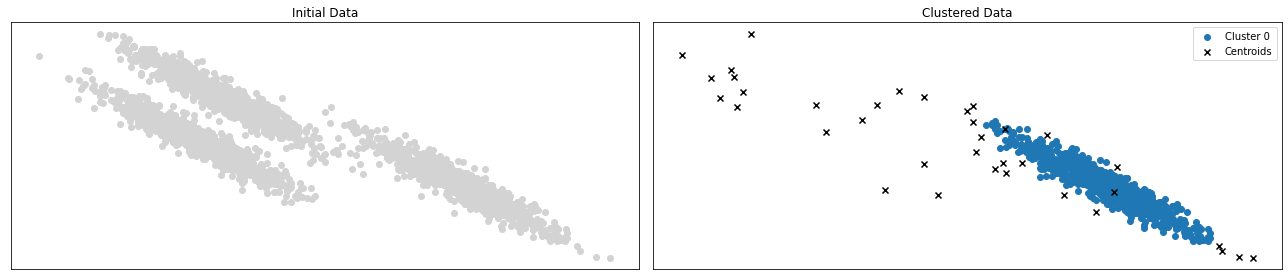

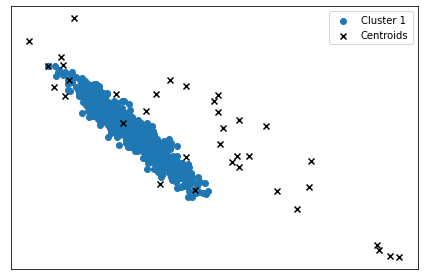

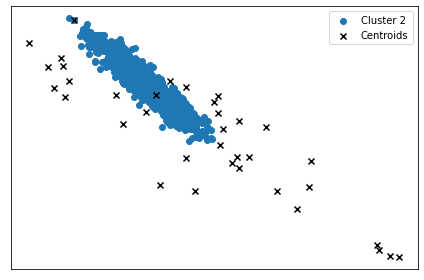

In [459]:
plt.figure(figsize=(18, 4))
plt.subplot(1,2,1)
plt.title('Initial Data')
plt.scatter(x[:,0], x[:,1], c='lightgrey')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.title('Clustered Data')
for idx, grp in enumerate(sts): 
    if cluster_size[idx] > threshold:
        plt.scatter(x[grp,0], x[grp,1], label='Cluster {}'.format(idx))
        plt.scatter(x[cen[idx],0], x[cen[idx],1], c='black', marker='x', label='Centroids')
        plt.legend(loc='best')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

Правимо насумичне боје кластера за визуализацију финалног резултата при чему кластере кардиналности мање од минималног прага бојимо црном бојом.

In [460]:
colors = []
def cluster_color(cen):
    for i in np.arange(len(cen)):
        if (cluster_size[i] > threshold):
            np.random.seed(i+123)
            colors.append(list(np.random.choice(range(256), size=3,)/255))
        else:
            colors.append([0, 0, 0])
    return colors
colors = cluster_color(cen)
colors

[[0.996078431372549, 0.42745098039215684, 0.49411764705882355],
 [0.807843137254902, 0.611764705882353, 0.06666666666666667],
 [0.7411764705882353, 0.615686274509804, 0.8862745098039215],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0]]

In [461]:
cluster_colors = np.zeros((x.shape[0],3))
for idx, grp in enumerate(sts):
    cluster_colors[grp] = colors[idx]

Финални резултат ТоМАТо алгоритма:

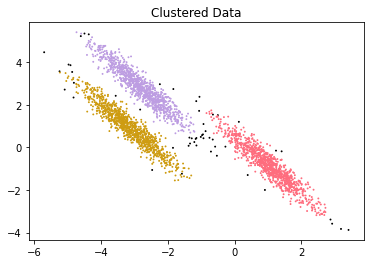

In [462]:
plt.figure(figsize=(6, 4))
plt.title('Clustered Data')
plt.scatter(x[:,0], x[:,1], c = cluster_colors, s=0.8)